# Last Worksheet!

We will cover 2 things today:

1. [Estimation when you only have 1 sample (like in IRL!)](#Estimation-with-only-one-sample)
2. [Getting R + Jupyter working for you outside of our course](#Getting-R-+-Jupyter-working-for-you-outside-of-our-course)

### Lecture and Tutorial Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:
- Explain why we don't have a sampling distribution in practice/real life.
- Define bootstrapping.
- Use R to created bootstrap distribution to approximate a sampling distribution.
- Contrast bootstrap and sampling distributions.

In [1]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
source('tests_worksheet_12.R')
source("cleanup_worksheet_12.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches




**Question 1.1** True/False:
<br> {points: 1}

In real life we typically take many samples from the population and create a sampling distribution when we perform estimation. True or False?

*Assign your answer to an object called `answer1.1`. Your answer should be a either "True" or "False", surrounded by quotes.*

In [2]:
# your code here
answer1.1 = 'False'

In [3]:
test_1.1()

[1] "Success!"


**Question 1.2** Ordering
<br> {points: 1}

Correctly re-order the steps for creating a bootstrap sample from those listed below. 

1. record the observation's value
2. repeat the above the same number of times as there are observations in the original sample 
3. return the observation to the original sample
4. randomly draw an observation from the original sample (which was drawn from the population)

Create your answer by reordering values below in the `answer1.2` vector with the correct order for the steps above for creating a bootstrap sample.

In [4]:
answer1.2 <- c(4, 1, 3, 2)
# your code here

In [5]:
test_1.2()

[1] "Success!"


**Question 1.3** Multiple choice
<br> {points: 1}

From the list below, choose the correct explanation of a bootstrap distribution for a point estimate:

A. a list of point estimates calculated from many samples drawn with replacement from the population

B. a list of point estimates calculated from many samples drawn without replacement from the population

C. a list of point estimates calculated from bootstrap samples drawn with replacement from a single sample (that was drawn from the population)

D. a list of point estimates calculated from bootstrap samples drawn without replacement from a single sample (that was drawn from the population)

*Assign your answer to an object called `answer1.3`. Your answer should be a single character surrounded by quotes.*

In [6]:
# your code here
answer1.3 = 'C'

In [7]:
test_1.3()

[1] "Success!"


**Question 1.4** Multiple choice
<br> {points: 1}

From the list below, choose the correct explanation of why, when performing estimation, we want to report a plausible **range** for the true population quantity we are trying to estimate along with the point estimate:

A. The point estimate is our best guess at the true population quantity we are trying to estimate

B. The point estimate will often not be the exact value of the true population quantity we are trying to estimate

C. The value of a point estimate from one sample might very well be different than the value of a point estimate from another sample.

D. B & C

F. A & C

E. None of the above

*Assign your answer to an object called `answer1.4`. Your answer should be a single character surrounded by quotes.*

In [8]:
# your code here
answer1.4 = 'D'

In [9]:
test_1.4()

[1] "Success!"


###  Continuing with our virtual population of Canadian seniors from last worksheet

Here we re-create the virtual population (ages of all Canadian seniors) we used in the last worksheet. It was bounded by realistic values ($\geq$ 65 and $\leq$ 118):

In [10]:
# run this cell to simulate a finite population
set.seed(4321) # DO NOT CHANGE
can_seniors <- tibble(age = (rexp(2000000, rate = 0.1)^2) + 65) %>% 
    filter(age <= 117, age >= 65)
head(can_seniors)

age
<dbl>
65.09234
92.77292
90.08786
100.98820
74.68310
65.54121


Let's remind ourselves of what this population looks like:

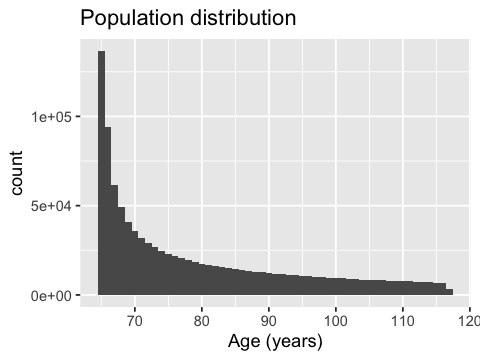

In [11]:
# run this cell 
options(repr.plot.width = 4, repr.plot.height = 3)
pop_dist <- ggplot(can_seniors, aes(age)) + 
    geom_histogram(binwidth = 1) +
    xlab("Age (years)") +
    ggtitle("Population distribution") 
pop_dist

### Estimate the mean age of Canadian Seniors

Let's say we are interested in estimating the mean age of Canadian Seniors. Given that we have the population (we created it) we could just calculate the mean age from this population data. However in real life, we usually only have one small-ish sample from the population. Also, from our experimentation with sampling distributions, we know that different random samples will give us different point estimates. We also know from these experiments that the point estimates from different random samples will mostly be close to the true population quanitity we are trying to estimate, and how close depends on the sample size.

What about in real life though, when we only have one sample? Can we say how close? Or at least give some plausible range of where we would expect the population quanitity we are trying to estimate to fall? Yes! We can do this using a method called bootstrapping! Let's explore how to create a bootstrap distribution from a single sample using R. And then we will discuss how the bootstrap distribution relates to the sampling distribution, and what it can tell us about the true population quantity we are trying to estimate.

Let's draw a single sample of size 40 from the population and visualize it:

In [12]:
# run this cell 
set.seed(12345) 
one_sample <- can_seniors %>% 
    rep_sample_n(40) %>% 
    ungroup() %>% # ungroup the data frame 
    select(age) # drop the replicate column 
head(one_sample)

age
<dbl>
65.07064
66.53276
73.28399
106.10351
65.00235
68.03932


> ### An aside
> To make this work with the `infer` package functions, we need to drop the first column (named `replicate`) as when we are bootstrapping we will be generating this column again. We also need to ungroup this data frame too...
>
> This is because in real life you would only have one sample (and hence no replicate column and the data would be ungrouped).

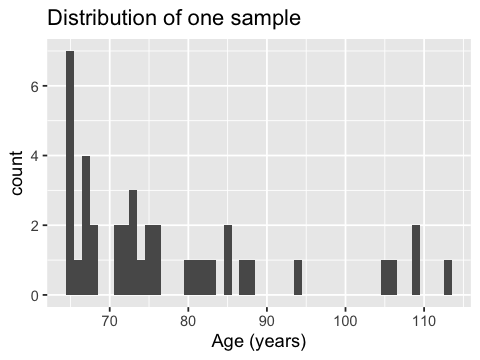

In [13]:
# run this cell 
one_sample_dist <- ggplot(one_sample, aes(age)) + 
    geom_histogram(binwidth = 1) +
    xlab("Age (years)") +
    ggtitle("Distribution of one sample")
one_sample_dist

**Question 1.5** 
<br> {points: 1}

Use `summarise` to calculate the mean age (our point estimate of interest) from the random sample you just took (`one_sample`):

Name this data frame `one_sample_estimates` which has a single column named `mean`.

In [14]:
# your code here
one_sample_estimates = summarize(one_sample, mean=mean(age))
one_sample_estimates

mean
<dbl>
77.8202


In [15]:
test_1.5()

[1] "Success!"


**Question 1.6** 
<br> {points: 1}

To generate a single bootstrap sample in R, we can use the `rep_sample_n` function as we did when we were creating our sampling distribution, however this time we change the argument for `replace` from its default value of `FALSE` to `TRUE`.

Use `rep_sample_n` to take a single bootstrap sample from the sample you drew from the population. Name this bootstrap sample `boot1`.

Use 4321 as the seed.

In [16]:
set.seed(4321)  # DO NOT CHANGE!
# boot1 <- ... %>%
#    rep_sample_n(size = ..., replace = ..., reps = ...)
# your code here

boot1 <- one_sample %>%
   rep_sample_n(size = 40, replace = T, reps = 1)


head(boot1)

replicate,age
<int>,<dbl>
1,81.12797
1,94.40375
1,65.43618
1,71.52872
1,73.58150
1,70.87062


In [17]:
test_1.6()

[1] "Success!"


**Question 1.7** Multiple choice
<br> {points: 1}

Why do we change `replace` to `TRUE`?

A. Taking a bootstrap sample involves drawing observations from the original population without replacement

B. Taking a bootstrap sample involves drawing observations from the original population with replacement

C. Taking a bootstrap sample involves drawing observations from the original sample without replacement

D. Taking a bootstrap sample involves drawing observations from the original sample with replacement

*Assign your answer to an object called `answer1.7`. Your answer should be a single character surrounded by quotes.*

In [18]:
# your code here
answer1.7 = 'D'

In [19]:
test_1.7()

[1] "Success!"


**Question 1.8** 
<br> {points: 1}

Visualize the distribution of the bootstrap sample you just took (`boot1`) that was just created by plotting a histogram using `binwidth = 1` in the `geom_histogram` argument. Name the plot `boot1_dist` and give the plot (using `ggtitle`) and the x axis a descriptive label.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



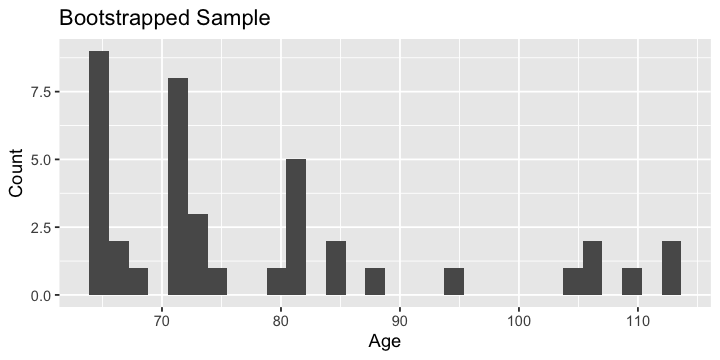

In [31]:
# your code here
boot1_dist = boot1 %>%
    ggplot(aes(age)) +
        geom_histogram() +
        labs(x = "Age", y = "Count", title = "Bootstrapped Sample")
boot1_dist

In [32]:
test_1.8()

[1] "Success!"


Let's now compare our bootstrap sample to the original random sample that we drew from the population:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



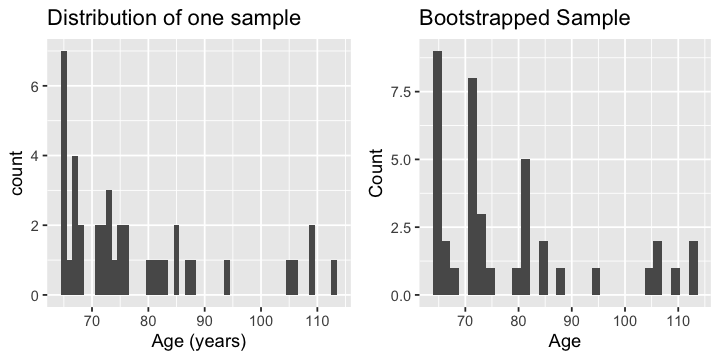

In [29]:
# run this code cell
options(repr.plot.width = 6)
grid.arrange(one_sample_dist, boot1_dist, ncol = 2)

Earlier we calculate the mean of our original sample to be about 79.6 years. What is the mean of our bootstrap sample?

In [33]:
# run this cell
summarise(boot1, mean = mean(age))

replicate,mean
<int>,<dbl>
1,78.60784


We see that original sample distrbution and the bootstrap sample distribution are of similar shape, but not identical. They also have different means. The difference of the frequency of the values in the bootstrap sample (and the difference of the value of the mean) comes from sampling from the original sample with replacement. Why sample with replacement? If we didn't we would end up with the original sample again. What we are trying to do with bootstrapping is to mimic drawing another sample from the population, without actually doing that. 

Why are we doing this? As mentioned earlier, in real life we typically only have one sample and thus we cannot create a sampling distribution that we can use to tell us about how we might expected our point estimate to behave if we took another sample. So what we can do, is use our sample as an estimate of our population, and sample from that with replacement (i.e., bootstrapping) many times to create many bootstrap samples. We can then calculate point estimates for each bootstrap sample and create a bootstrap distribution of our point estimates and use this as a proxy for a sampling distribution. We can finally use this bootstrap distribution of our point estimates to suggest how we might expected our point estimate to behave if we took another sample.

**Question 1.9** 
<br> {points: 1}

What do 6 different bootstrap samples look like? Use `rep_sample_n` to create a single data frame with 6 bootstrap samples drawn from the original sample we drew from the population, `one_sample`. Name the data frame `boot6`.

Set the seed as 1234.

In [34]:
set.seed(1234)
# your code here
boot6 = one_sample %>%
    rep_sample_n(size=40, replace=T, reps=6)
head(boot6)
tail(boot6)

replicate,age
<int>,<dbl>
1,87.60507
1,75.37056
1,109.00773
1,65.11363
1,85.30635
1,65.00235


replicate,age
<int>,<dbl>
6,81.12797
6,67.13013
6,71.52872
6,109.00773
6,65.42416
6,108.65109


In [35]:
test_1.9()

[1] "Success!"


**Question 2.0** 
<br> {points: 1}

Now visualize the six bootstrap sample distributions from `boot6` by faceting the `replicate` column. Name the plot object `boot6_dist` and give the plot (using `ggtitle`) and the x axis a descriptive label.

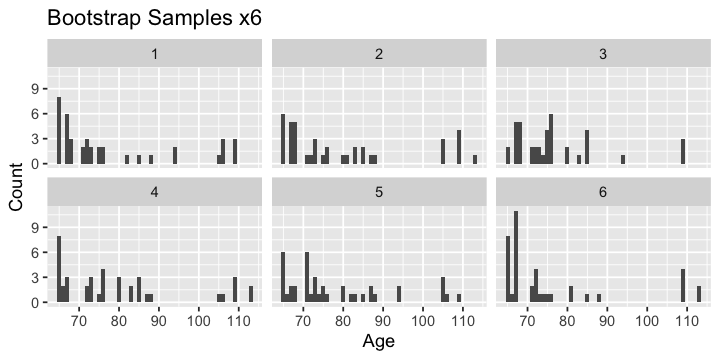

In [38]:
# boot6_dist <- ggplot(...) +
#   ...(binwidth = 1) +
#  facet_wrap(~ ...)
# your code here
boot6_dist <- ggplot(boot6, aes(age)) +
  geom_histogram(binwidth = 1) +
 facet_wrap(~ replicate) +
 labs(x="Age", y="Count", title="Bootstrap Samples x6")
boot6_dist

In [39]:
test_2.0()

[1] "Success!"


**Question 2.1** 
<br> {points: 1}

Calculate the mean of these 6 bootstrap samples using `group_by` and `summarize`. Name the data frame `boot6_means`.

In [40]:
# your code here
boot6_means = boot6 %>%
    group_by(replicate) %>%
    summarize(mean = mean(age))
boot6_means

replicate,mean
<int>,<dbl>
1,78.14533
2,79.82831
3,76.74020
4,79.93621
5,78.30400
6,76.17892


In [41]:
test_2.1()

[1] "Success!"


**Question 2.2** 
<br> {points: 1}

Let's now take 1000 bootstrap samples from the original sample we drew from the population (`one_sample`) using `rep_sample_n`. Name the data frame `boot1000`.

Set the seed as 1234.

In [42]:
set.seed(1234)
# your code here
boot1000 = one_sample %>%
    rep_sample_n(size = 40, replace = T, reps = 1000)
head(boot1000)
tail(boot1000)

replicate,age
<int>,<dbl>
1,87.60507
1,75.37056
1,109.00773
1,65.11363
1,85.30635
1,65.00235


replicate,age
<int>,<dbl>
1000,65.03099
1000,65.42416
1000,108.65109
1000,67.32232
1000,106.10351
1000,84.94389


In [43]:
test_2.2()

[1] "Success!"


**Question 2.3** 
<br> {points: 1}

Calculate the mean of these 1000 bootstrap samples using `group_by` and `summarize`. Name the data frame `boot1000_means`.

In [44]:
# your code here
boot1000_means = boot1000 %>%
    group_by(replicate) %>%
    summarize(mean = mean(age))
head(boot1000_means)
tail(boot1000_means)

replicate,mean
<int>,<dbl>
1,78.14533
2,79.82831
3,76.74020
4,79.93621
5,78.30400
6,76.17892


replicate,mean
<int>,<dbl>
995,76.76930
996,78.14654
997,77.59243
998,79.97578
999,76.65296
1000,77.10738


In [45]:
test_2.3()

[1] "Success!"


**Question 2.4** 
<br> {points: 1}

Visualize the distribution of the bootstrap sample point estimates (`boot1000_means`) you just calculated by plotting a histogram using `binwidth = 1` in the `geom_histogram` argument. Name the plot `boot_est_dist` and give the plot (using `ggtitle`) and the x axis a descriptive label.

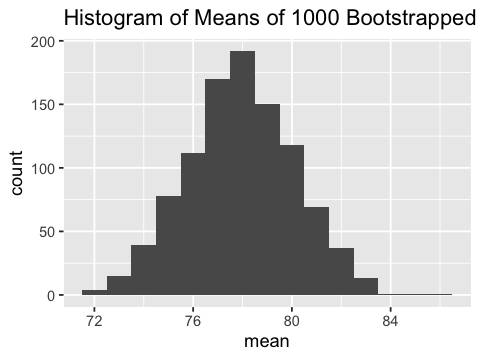

In [47]:
options(repr.plot.width = 4, repr.plot.height = 3)
# your code here
boot_est_dist = boot1000_means %>%
    ggplot(aes(mean)) +
    geom_histogram(binwidth = 1) +
    ggtitle("Histogram of Means of 1000 Bootstrapped Samples")
boot_est_dist

In [48]:
test_2.4()

[1] "Success!"


How does the bootstrap distribution above compare to the sampling distribution? Let's visualize them side by side:

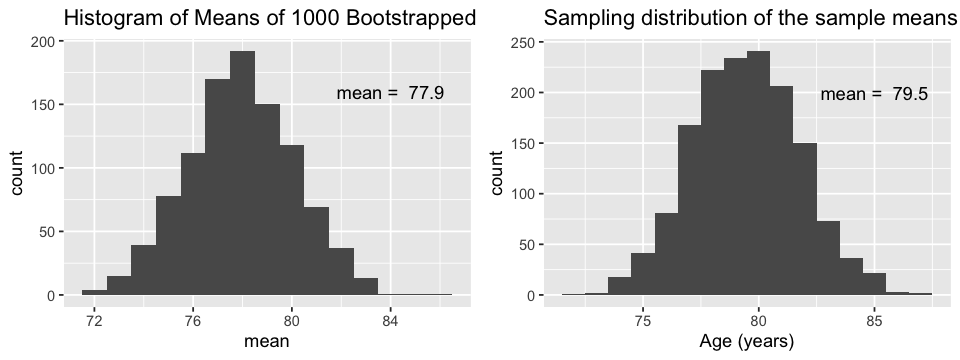

In [49]:
# run this cell

# create sampling distribution histogram
set.seed(4321)
samples <- rep_sample_n(can_seniors, size = 40, reps = 1500)
sample_estimates <- samples %>% 
    group_by(replicate) %>% 
    summarise(mean = mean(age))
sampling_dist <-  ggplot(sample_estimates, aes(x = mean)) +
    geom_histogram(binwidth = 1) +
    xlab("Age (years)") +
    ggtitle("Sampling distribution of the sample means") +
    annotate("text", x = 85, y = 200, label = paste("mean = ", round(mean(sample_estimates$mean), 1)))

# annotate distribution mean to the bootstrap dist
boot_est_dist <- boot_est_dist + 
    annotate("text", x = 84, y = 160, label = paste("mean = ", round(mean(boot1000_means$mean), 1)))

# plot bootstrap distribution beside sampling distribution
options(repr.plot.width = 8)
grid.arrange(boot_est_dist, sampling_dist, ncol = 2)

Reminder: the true population quantity we are trying to estimate, the population mean, is about 79.3 years. We know this because we created this population and calculated this value. In real life we wouldn't know this value.

**Question 2.5** True/False
<br> {points: 1}

The mean of the distribution of the bootstrap sample means is the same value as the mean of the sampling distribution of the sample means. True or False?

*Assign your answer to an object called `answer2.5`. Your answer should be a either "True" or "False", surrounded by quotes.*

In [50]:
# your code here
answer2.5 = "False"

In [51]:
test_2.5()

[1] "Success!"


**Question 2.6** True/False
<br> {points: 1}

The mean of the distribution of the bootstrap sample means is not the same value as the mean of the sampling distribution of the sample means because the bootstrap samples were drawn from the sample, whereas the samples that were used to create the sampling distribution were drawn from the population. True or False?

*Assign your answer to an object called `answer2.6`. Your answer should be a either "True" or "False", surrounded by quotes.*

In [54]:
# your code here
answer2.6 = "True"

In [55]:
test_2.6()

[1] "Success!"


**Question 2.7** True/False
<br> {points: 1}

The shape and spread (i.e. width) of the distribution of the bootstrap sample means is a poor approximation of the  shape and spread of the sampling distribution of the sample means. True or False?

*Assign your answer to an object called `answer2.7`. Your answer should be a either "True" or "False", surrounded by quotes.*

In [56]:
# your code here
answer2.7 = "False"

In [57]:
test_2.7()

[1] "Success!"


**Question 2.8** True/False
<br> {points: 1}

In real life, where we only have one sample and cannot create a sampling distribution, the distribution of the bootstrap sample estimates (here means) can suggest how we might expected our point estimate to behave if we took another sample.

*Assign your answer to an object called `answer2.8`. Your answer should be a either "True" or "False", surrounded by quotes.*

In [58]:
# your code here
answer2.8 = "True"

In [59]:
test_2.8()

[1] "Success!"


### Using the bootstrap distribution to calculate a plausible range for point estimates

Once we have created a bootstrap distribution, we can use it to suggest a plausible range where we might expect the true population quantity to lie. One formal name for a commonly used plausible range is called a confidence interval. Confidence intervals can be set at different levels, an example of a commonly used level is 95%. When we report a point estimate with a 95% confidence interval as the plausible range, formally we are saying that if we repeated this process of building confidence intervals more times with more samples, we’d expect ~ 95% of them to contain the value of the population quantity.

> How do you choose a level for a confidence interval? You have to consider the downstream application of your estimation and what the cost/consequence of an incorrect estimate would be. The higher the cost/consequence, the higher a confidence level you would want to use. You will learn more about this in later Statistics courses.

To calculate a 95% confidence interval using bootstrapping, we essentially order the values in our bootstrap distribution and then take the value at the 2.5th percentile as the lower bound of the plausible range, and the 97.5th percentile as the upper bound of the plausible range. 

In [60]:
# run this cell
boot1000_means %>% 
    select(mean) %>% 
    pull() %>% 
    quantile(c(0.025, 0.975))

2.5%    97.5% 
73.72699 82.08650

Thus, to finish our estimation of the population quantity that we are trying to estimate, we would report the point estimate and the lower and upper bounds of our confidence interval. We would say something like this:

Our sample mean age for Canadian seniors was measured to be 77.8 years, and we’re 95% “confident” that the true population mean for Canadian seniors is between (73.7, 82.0). 

Here our 95% confidence interval does contain the true population mean for Canadian seniors, 79.3 years - pretty neat! However, in real life we would never be able to know this because we only have observations from a single sample, not the whole population.

**Question 2.9** True/False
<br> {points: 1}

Assuming we knew the true population quantity we are trying to estimate (so we could verify this):

For any sample we take, if we use bootstrapping to calculate the 95% confidence intervals, the true population quantity we are trying to estimate would always fall within the lower and upper bounds of the confidence interval. True or False?

*Assign your answer to an object called `answer2.9`. Your answer should be a either "True" or "False", surrounded by quotes.*

In [61]:
# your code here
answer2.9 = "False"

In [62]:
test_2.9()

[1] "Success!"


You are done the part we are going to grade!!! The rest of the worksheet will help you get a copy of your homework from this course somewhere where you can access it after you lose access to our server.

## Getting R + Jupyter working for you outside of our course

At some point after the exam, you will lose access to the JupyterHub server where you have been doing your course work. If you want to continue to use R + Jupyter (for other courses at UBC, or for your work after UBC) you have two options:

1. a server solution
2. a local installation solution

We will point you to how you can do both, as well as provide [guidance to take a copy of your homework from our Canvas JupyterHub server](#Getting-your-files-off-of-the-Canvas-JupyterHub).

## Getting your files off of the Canvas JupyterHub

1. On the Canvas JupyterHub open a terminal and type: `tar -zcvf dsci-100.tar.gz dsci-100`
2. Go to the JupyterHub Control Panel/Home and click the box beside the file `dsci-100.tar.gz`, and then click "Download"
3. Log onto either the https://ubc.syzygy.ca/ (CWL authentication) or https://cybera.syzygy.ca/ (Google authentication) servers
4. Click the white "Upload" button (beside the "New" button), and select `tar -zxvf dsci-100.tar.gz`. Then click the blue "Upload" button to complete the upload.
5. open a terminal and type: `tar -zxvf dsci-100.tar.gz` 

You should have your files now available on either of those servers above. 

*On Mac or Linux `tar` also works in terminal, and so you can use this strategy to have the files available locally, however you will need Jupyter installed to view them.*

### 1. A Server Solution

- As a student at UBC, you have access to another JupyterHub that you can access using your UBC CWL: https://ubc.syzygy.ca/
- If you have a Google account, you have access to another JupyterHub that does not depend on you being a UBC student (i.e., having a valid CWL): https://cybera.syzygy.ca/

### 2. A Local Installation Solution

- Depending on your device, you may be able to install Jupyter and R on it. Below we provide instructions for the 3 major operating systems ([Mac](#A.-Install-Jupyter-+-R-on-Mac), [Windows](#B.-Install-Jupyter-+-R-on-Windows) and [Linux]())

### A. Install Jupyter + R on Mac

#### A.1. Install R

Go to https://cran.r-project.org/bin/macosx/ and download the latest version of R for Mac (Should look something like this: R-3.5.1.pkg). Open the file and follow the installer instructions.

#### A.2. Install Jupyter
Head to https://www.anaconda.com/download/#macos and download the Anaconda version for Mac OS. Follow the instructions on that page to run the installer. *Anaconda is a software bundle installs Jupyter and Python and a few other tools. We recommend using it because it makes installation much simpler than other methods.*

#### A.3. Install the IR kernel 
The IR kernel lets you connect R with Jupyter, to install it follow the instructions below:

- Open terminal ([how to video](https://www.youtube.com/watch?v=zw7Nd67_aFw)), and type `R` to open R.

- Type the following commands into R:

`install.packages('IRkernel',  repos = 'http://cran.us.r-project.org')`

`IRkernel::installspec(user = FALSE)`

- Next, exit R by typing: `q()` (type `n` when prompted to not save the workspace)

#### A.4 Test if it works:

- Open terminal and type: `jupyter notebook`

The above command should open a web browser, with Jupyter's home inside it. Try creating a new R notebook and running some simple R code (e.g., `print("hello!")`) to test that it works.

### B. Install Jupyter + R on Windows

#### B.1. Install R

Go to <https://cran.r-project.org/bin/windows/base/> and download the latest version of R for Windows (Should look something like this: Download R 3.5.1 for Windows). Open the file and follow the installer instructions.

#### B.2. Install Jupyter
Head to <https://www.anaconda.com/download/#windows> and download the Anaconda version for Windows with Python 3.6. After the download has finished, run the installer selecting the following options:
  - On the **Advanced Installation Options** page, check both boxes (see image below)
  - For all other pages, use the default options

<img align="left" src="https://github.com/UBC-MDS/UBC-MDS.github.io/raw/master/resources_pages/imgs/anaconda_windows.png" width="550">


#### B.3. Install the IR kernel 
The IR kernel lets you connect R with Jupyter, to install it follow the instructions below:

- Open R (double click on Desktop Icon or open it using the START menu)

- Type the following commands into R:

`install.packages('IRkernel',  repos = 'http://cran.us.r-project.org')`

`IRkernel::installspec(user = FALSE)`

- Next, exit/close R

#### B.4 Test if it works:

- Open Windows Command Prompt (select the Start button, type cmd, and click Command Prompt from the list) and type: `jupyter notebook`

The above command should open a web browser, with Jupyter's home inside it. Try creating a new R notebook and running some simple R code (e.g., `print("hello!")`) to test that it works.

### C. Install Jupyter + R on Linux

#### C.1. Install R

Follow the instructiond here: https://ubc-mds.github.io/resources_pages/install_ds_stack_ubuntu/#r-irkernel-and-rstudio (note - you do not need to install RStudio).


#### C.2. Install Jupyter
Head to https://www.anaconda.com/download/#linux and download the Anaconda version for Linux with Python 3.6. Follow the instructions on that page to run the installer. *Anaconda is a software bundle installs Jupyter and Python and a few other tools. We recommend using it because it makes installation much simpler than other methods.*

#### C.3. Install the IR kernel 
The IR kernel lets you connect R with Jupyter, to install it follow the instructions below:

- Open the terminal, and type `R` to open R.

- Type the following commands into R:

`install.packages('IRkernel',  repos = 'http://cran.us.r-project.org')`

`IRkernel::installspec(user = FALSE)`

- Next, exit R by typing: `q()` (type `n` when prompted to not save the workspace)

#### C.4 Test if it works:

- Open terminal and type: `jupyter notebook`

The above command should open a web browser, with Jupyter's home inside it. Try creating a new R notebook and running some simple R code (e.g., `print("hello!")`) to test that it works.